In [1]:
pip install category-encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

In [3]:
def wrangle(filepath):
#     read data
    data = pd.read_csv(filepath)
    
#     remove column which have missing values more than 40%
    data.dropna(axis="columns", thresh=int(data.shape[0]*0.6), inplace=True)
    
    return data

In [4]:
data = wrangle("MS4S16.csv")
data.head()

,Diagnosis,Anhedonia,Apathy,Appetite,Concentration,Content,Delay,Delusion,Dep_Mood,Focus,...,Psychomotor,Race,Rumination,Sex,Sleep,Stress,Tension,Tired,Unusual_Thought,Withdrawal
0,1,4.501446,3.056575,9.283891,8.305502,0.006142,Yes,1.170842,8.177884,8.305502,...,3.854579,White,5.041432,Female,6.552082,5.915492,6.371877,4.537270,3.744410,5.242819
1,0,5.432608,0.307721,25.809400,5.060206,0.062209,Yes,2.272548,11.162913,5.060206,...,5.821110,White,4.656790,Male,5.558434,4.008265,2.238665,6.113746,0.720458,3.797242
2,0,6.557500,-1.412208,24.842012,6.504229,0.071532,No,1.439095,5.887363,6.504229,...,7.893102,Black,7.290494,Female,5.787561,7.177926,6.992499,5.557374,-0.491255,4.421288
3,0,5.429568,1.686157,24.175853,6.994948,0.278345,No,1.380185,8.943851,6.994948,...,3.812874,White,6.759339,Female,6.787287,2.866815,4.018286,6.136269,0.765388,2.299562
4,1,5.099846,-0.612506,45.808490,5.869212,0.004214,Yes,1.237976,6.741627,5.869212,...,5.119658,Black,6.190019,Male,7.748312,6.798220,5.063542,4.213723,0.705895,6.547707


## Data Preprocessing

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Diagnosis           5000 non-null   int64  
 1   Anhedonia           5000 non-null   float64
 2   Apathy              5000 non-null   float64
 3   Appetite            5000 non-null   float64
 4   Concentration       5000 non-null   float64
 5   Content             5000 non-null   float64
 6   Delay               5000 non-null   object 
 7   Delusion            5000 non-null   float64
 8   Dep_Mood            5000 non-null   float64
 9   Focus               5000 non-null   float64
 10  Hallucination       5000 non-null   float64
 11  Housing             5000 non-null   object 
 12  Intrusive_Thoughts  4170 non-null   float64
 13  Participant         5000 non-null   int64  
 14  Passive             5000 non-null   float64
 15  Psychomotor         5000 non-null   float64
 16  Race  

In [6]:
# String Data Summary
data.select_dtypes(exclude="number").describe()

,Delay,Housing,Race,Sex
count,5000,5000,5000,5000
unique,2,2,4,2
top,Yes,Stable,White,Female
freq,2571,4674,1838,2762


All Seems Good With String Data

In [7]:
# Numerical Data Summary
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Diagnosis,5000.0,0.505800,0.500016,0.000000,0.000000,1.000000,1.000000,1.000000
Anhedonia,5000.0,6.502860,1.488151,1.098854,5.495361,6.485527,7.489218,11.603140
Apathy,5000.0,2.478849,1.730810,-3.211011,1.265128,2.427409,3.642059,8.803433
Appetite,5000.0,27.070029,14.202618,0.141074,16.724108,25.165292,35.447666,113.438734
Concentration,5000.0,6.519924,1.474846,1.299964,5.528181,6.498042,7.519759,11.649649
Content,5000.0,0.279407,0.834494,0.000187,0.018655,0.064259,0.215773,21.001327
Delusion,5000.0,2.637389,1.440347,-2.127037,1.629919,2.558146,3.588012,8.978785
Dep_Mood,5000.0,5.727062,3.284501,0.000000,4.678095,6.752196,8.045706,12.003550
Focus,5000.0,6.519924,1.474846,1.299964,5.528181,6.498042,7.519759,11.649649
Hallucination,5000.0,65.073832,223.943469,0.027350,4.113962,12.764604,41.814204,6287.163151


In [8]:
# Column Tired have infinite value so drop it
data.drop("Tired", axis="columns", inplace=True)

In [9]:
# Correlation of data
data.corr()

,Diagnosis,Anhedonia,Apathy,Appetite,Concentration,Content,Delusion,Dep_Mood,Focus,Hallucination,Intrusive_Thoughts,Participant,Passive,Psychomotor,Rumination,Sleep,Stress,Tension,Unusual_Thought,Withdrawal
Diagnosis,1.000000,-0.330155,0.324644,-0.006947,0.329591,-0.134793,0.408914,-0.079799,0.329591,0.170579,-0.550806,NaN,-0.017115,-0.230957,-0.596503,0.025147,0.458557,0.516142,0.394249,0.219410
Anhedonia,-0.330155,1.000000,-0.087146,0.028458,-0.103457,0.047178,-0.137018,-0.001519,-0.103457,-0.053082,0.195297,NaN,0.010750,0.060917,0.202069,-0.014005,-0.141027,-0.162854,-0.119673,-0.075209
Apathy,0.324644,-0.087146,1.000000,0.002106,0.107747,-0.064405,0.145132,-0.031882,0.107747,0.026718,-0.182515,NaN,-0.003923,-0.071669,-0.193687,0.008407,0.157259,0.178003,0.812859,0.093710
Appetite,-0.006947,0.028458,0.002106,1.000000,-0.015122,-0.028787,-0.009600,-0.007046,-0.015122,-0.002647,0.023354,NaN,0.004908,-0.023503,0.020573,0.016495,0.006104,0.011619,-0.001190,0.005644
Concentration,0.329591,-0.103457,0.107747,-0.015122,1.000000,-0.038601,0.115106,-0.043574,1.000000,0.038687,-0.167951,NaN,-0.006648,-0.071971,-0.190818,-0.030384,0.181396,0.184090,0.127945,0.072692
Content,-0.134793,0.047178,-0.064405,-0.028787,-0.038601,1.000000,-0.062656,0.030003,-0.038601,-0.031946,0.072818,NaN,-0.012404,0.002365,0.074279,-0.014943,-0.060263,-0.075790,-0.073211,-0.054486
Delusion,0.408914,-0.137018,0.145132,-0.009600,0.115106,-0.062656,1.000000,-0.045544,0.115106,0.446102,-0.232700,NaN,-0.012481,-0.101670,-0.246398,0.019044,0.185466,0.215114,0.172897,0.108807
Dep_Mood,-0.079799,-0.001519,-0.031882,-0.007046,-0.043574,0.030003,-0.045544,1.000000,-0.043574,-0.011256,0.022233,NaN,-0.404670,0.018221,0.011648,0.011746,-0.058349,-0.064671,-0.038897,-0.042382
Focus,0.329591,-0.103457,0.107747,-0.015122,1.000000,-0.038601,0.115106,-0.043574,1.000000,0.038687,-0.167951,NaN,-0.006648,-0.071971,-0.190818,-0.030384,0.181396,0.184090,0.127945,0.072692
Hallucination,0.170579,-0.053082,0.026718,-0.002647,0.038687,-0.031946,0.446102,-0.011256,0.038687,1.000000,-0.099086,NaN,0.007514,-0.061639,-0.110613,0.015907,0.095685,0.110464,0.048999,0.028669


In [10]:
data["Participant"].unique()

array([1], dtype=int64)

In [11]:
# Participant column have same value in each observation so we can remove that column
data.drop("Participant", axis="columns", inplace=True)

<AxesSubplot:>

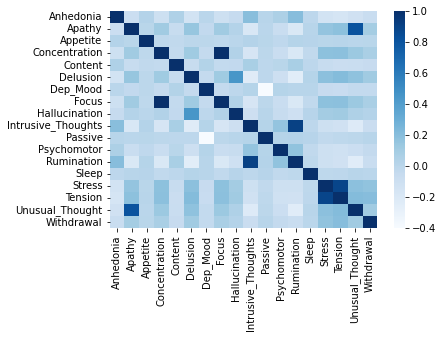

In [12]:
# correlation heatmap of features excluding target variable diagnosis
sns.heatmap(data.drop("Diagnosis", axis="columns").corr(), cmap="Blues")

Some Features Are Highly Correlated With Each Other Like:
Stress & Sleep, Focus & Concentration, Rumination & Intrusive_Thoughts, Apathy & Unusual_Thought
These can affect our model prediction so we will remove one from each

In [13]:
data.drop(columns=["Unusual_Thought","Focus","Intrusive_Thoughts","Sleep"], inplace=True)

<AxesSubplot:>

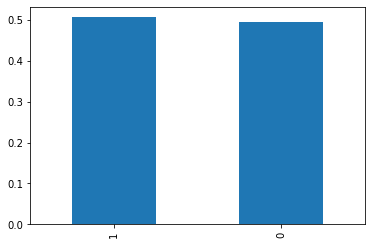

In [14]:
# Distribution of data between two target categories
data["Diagnosis"].value_counts(normalize=True).plot(kind="bar")

<AxesSubplot:ylabel='Race'>

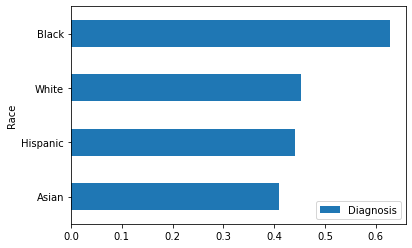

In [15]:
race_pivot = pd.pivot_table(data, index="Race", values="Diagnosis", aggfunc=np.mean).sort_values(by="Diagnosis")
race_pivot.plot(kind="barh", xlabel="Race")

<AxesSubplot:ylabel='Gender'>

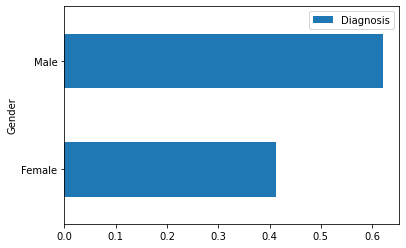

In [16]:
gender_pivot = pd.pivot_table(data, index="Sex", values="Diagnosis", aggfunc=np.mean).sort_values(by="Diagnosis")
gender_pivot.plot(kind="barh", xlabel="Gender")

<AxesSubplot:ylabel='Housing'>

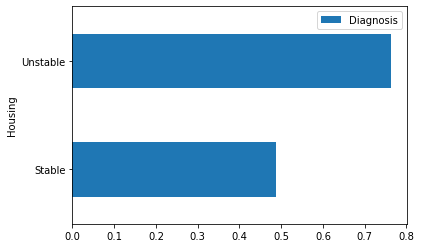

In [17]:
housing_pivot = pd.pivot_table(data, index="Housing", values="Diagnosis", aggfunc=np.mean).sort_values(by="Diagnosis")
housing_pivot.plot(kind="barh", xlabel="Housing")

<AxesSubplot:ylabel='Delay'>

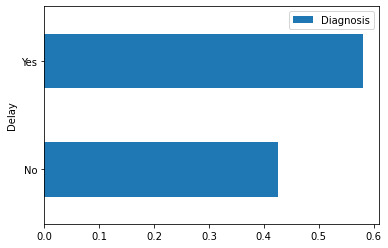

In [18]:
delay_pivot = pd.pivot_table(data, index="Delay", values="Diagnosis", aggfunc=np.mean).sort_values(by="Diagnosis")
delay_pivot.plot(kind="barh", xlabel="Delay")

## Classification

classifying cases of our schizophrenia-like 
illness (Diagnosis=1) from controls (Diagnosis=0) or predicting one of the numerical features using 
regression techniques

In [19]:
X = data.drop(columns="Diagnosis")
y = data["Diagnosis"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
model = make_pipeline(OrdinalEncoder(), SimpleImputer(), LogisticRegression(max_iter=2000))
model.fit(X_train, y_train)

C:\Users\DataWizard\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Delay', 'Housing', 'Race', 'Sex'],
                                mapping=[{'col': 'Delay',
                                          'data_type': dtype('O'),
                                          'mapping': Yes    1
No     2
NaN   -2
dtype: int64},
                                         {'col': 'Housing',
                                          'data_type': dtype('O'),
                                          'mapping': Stable      1
Unstable    2
NaN        -2
dtype: int64},
                                         {'col': 'Race',
                                          'data_type': dtype('O'),
                                          'mapping': Black       1
Hispanic    2
Asian       3
White       4
NaN        -2
dtype: int64},
                                         {'col': 'Sex', 'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dt

In [22]:
# Prediction
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [23]:
# Accuracy Score
print(f"Train Accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred)}")

Train Accuracy: 0.91425
Test Accuracy: 0.921


In [24]:
# Classification Report of Train Data
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1959
           1       0.92      0.91      0.92      2041

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



In [25]:
# Classification Report of Test Data
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       512
           1       0.93      0.91      0.92       488

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



## Linear Regression

In [54]:
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [58]:
y_pred = model.predict(X_test)

In [59]:
math.sqrt(mean_squared_error(y_test,y_pred))

0.2810693864511039

In [60]:
r2_score(y_test,y_pred)

0.6838178790983607

## Clustering Kmeans

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

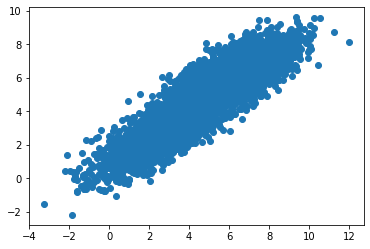

In [27]:
plt.scatter(data['Stress'],data['Tension'])

In [28]:
km = KMeans(n_clusters=3)
km

KMeans(n_clusters=3)

In [29]:
y_predicted = km.fit_predict(data[['Diagnosis','Stress','Tension']])
y_predicted

array([1, 0, 1, ..., 1, 1, 2])

In [30]:
data['cluster'] = y_predicted
data.head()

,Diagnosis,Anhedonia,Apathy,Appetite,Concentration,Content,Delay,Delusion,Dep_Mood,Hallucination,Housing,Passive,Psychomotor,Race,Rumination,Sex,Stress,Tension,Withdrawal,cluster
0,1,4.501446,3.056575,9.283891,8.305502,0.006142,Yes,1.170842,8.177884,12.831823,Stable,4.385417,3.854579,White,5.041432,Female,5.915492,6.371877,5.242819,1
1,0,5.432608,0.307721,25.809400,5.060206,0.062209,Yes,2.272548,11.162913,38.979963,Stable,2.491285,5.821110,White,4.656790,Male,4.008265,2.238665,3.797242,0
2,0,6.557500,-1.412208,24.842012,6.504229,0.071532,No,1.439095,5.887363,11.296530,Stable,-999.000000,7.893102,Black,7.290494,Female,7.177926,6.992499,4.421288,1
3,0,5.429568,1.686157,24.175853,6.994948,0.278345,No,1.380185,8.943851,4.237368,Stable,-999.000000,3.812874,White,6.759339,Female,2.866815,4.018286,2.299562,2
4,1,5.099846,-0.612506,45.808490,5.869212,0.004214,Yes,1.237976,6.741627,0.863636,Stable,7.999254,5.119658,Black,6.190019,Male,6.798220,5.063542,6.547707,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


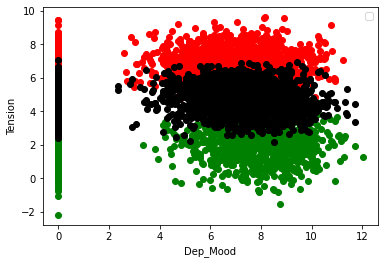

In [31]:
data1 = data[data.cluster==0]
data2 = data[data.cluster==1]
data3 = data[data.cluster==2]
plt.scatter(data1.Dep_Mood,data1['Tension'],color='green')
plt.scatter(data2.Dep_Mood,data2['Tension'],color='red')
plt.scatter(data3.Dep_Mood,data3['Tension'],color='black')


plt.xlabel('Dep_Mood')
plt.ylabel('Tension')
plt.legend()

In [32]:
km.cluster_centers_

array([[0.05736981, 1.83014574, 2.11125805],
       [0.72497366, 7.06298755, 6.72294573],
       [0.55256475, 4.62315059, 4.79996415]])

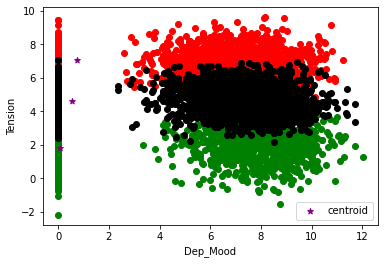

In [33]:
data1 = data[data.cluster==0]
data2 = data[data.cluster==1]
data3 = data[data.cluster==2]
plt.scatter(data1.Dep_Mood,data1['Tension'],color='green')
plt.scatter(data2.Dep_Mood,data2['Tension'],color='red')
plt.scatter(data3.Dep_Mood,data3['Tension'],color='black')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color = 'purple', marker='*',label='centroid')
plt.xlabel('Dep_Mood')
plt.ylabel('Tension')
plt.legend()

In [34]:
k_rng = range(1,10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(data[['Stress','Tension']])
    sse.append(km.inertia_)

In [35]:
sse

[43892.966748401,
 15639.232612108037,
 9043.96377231856,
 6397.347972877326,
 5041.295784429911,
 4279.952999360986,
 3791.045265080508,
 3402.6377459763307,
 3080.2510535604024]

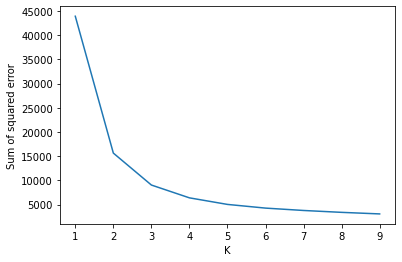

In [36]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

## Hierarchical  Clustering

In [37]:
from sklearn.datasets import make_blobs
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [38]:
dataset = make_blobs(n_samples = 200,
                    n_features = 2,
                    centers = 4,
                    cluster_std = 1.6,
                    random_state = 50)

In [39]:
#dataset

In [40]:
points = dataset[0]

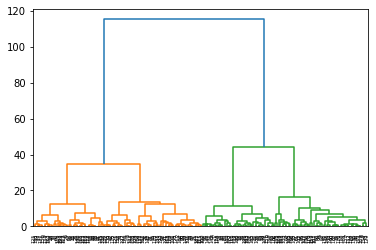

In [41]:
##create a dendrogram
dendrogram = sch.dendrogram(sch.linkage(points, method ='ward'))

In [42]:
hc = AgglomerativeClustering(n_clusters=4,affinity = 'enclidean', linkage = 'ward')

Conclude your notebook with a final conclusions, evaluations and recommendations section, 
drawing all of the analysis together and highlighting any limitations of the work done


In that code first we analyze the data and explore it in better way and perform statistics analysis, then we perform classification algorithm with diagnosis the illness with gender, race, delay etc. We do logistic regression and perform train and test analysis. Then, we perform clustering with respect of KMeans and Hierarchical Clustering. The conclusion will be that we should added more categorical data in that dataset to more precise analysis and highlighting the diagnosis in more better way. The evaluation tell us that the supervised learning will give us mature data and predict the data in good way. 
The limitation will be of that study is data is need more maturity for rest of the analysis and results.

Understand the code you have written

In that code first we analyze the data and explore it in better way and perform statistics analysis, then we perform classification algorithm with diagnosis the illness with gender, race, delay etc. We do logistic regression and perform train and test analysis. Then, we perform clustering with respect of KMeans and Hierarchical Clustering.

Can explain the algorithms utilised and the results obtained

Yes, the result that we are looking for is obtained and all the supervised and unsupervised machine learning algorithm is running successfully.